In [1]:
from __future__ import division, print_function, unicode_literals


import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

tf.reset_default_graph()

np.random.seed(42)
tf.set_random_seed(42)

/home/inderjeet78/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


# Training data prepration

In [3]:
c1_x = mnist.train.images[mnist.train.labels==6]
c1_y = mnist.train.labels[mnist.train.labels==6]
c1_y = c1_y[:,None]
other_x = mnist.train.images[mnist.train.labels!=6]
other_y = mnist.train.labels[mnist.train.labels!=6]
other_y=other_y[:,None]

np.random.seed(42)
c1 = np.concatenate((c1_x,c1_y),axis=1)
others = np.concatenate((other_x,other_y), axis=1)
print(c1.shape)
print(others.shape)
print(others)
np.random.shuffle(others)
others = np.array(others)
print(others.shape)
others321 = others[0:321,:]
print(others321.shape)
train = np.concatenate((c1,others321),axis=0)
np.random.shuffle(train)
X_train = train[:,0:-1]
Y_train = train[:,-1]
Y_train[Y_train==0]=1
Y_train[Y_train==6]=0
Y_train[Y_train!=0]=1

(5417, 785)
(49583, 785)
[[0. 0. 0. ... 0. 0. 7.]
 [0. 0. 0. ... 0. 0. 3.]
 [0. 0. 0. ... 0. 0. 4.]
 ...
 [0. 0. 0. ... 0. 0. 3.]
 [0. 0. 0. ... 0. 0. 5.]
 [0. 0. 0. ... 0. 0. 8.]]
(49583, 785)
(321, 785)


In [4]:
sum(Y_train)

321.0

# Validation data prepration

In [5]:
np.random.seed(42)
valX_ones = mnist.validation.images[mnist.validation.labels==6]
valY_ones = mnist.validation.labels[mnist.validation.labels==6]
valX_others = mnist.validation.images[mnist.validation.labels!=6]
valY_others = mnist.validation.labels[mnist.validation.labels!=6]
valY_ones = valY_ones[:,None]
valY_others = valY_others[:,None]
val_ones = np.concatenate((valX_ones,valY_ones),axis=1)
val_others = np.concatenate((valX_others,valY_others),axis=1)
np.random.shuffle(val_others)
val_others137 = val_others[0:137,:]
val = np.concatenate((val_ones,val_others137),axis=0)
np.random.shuffle(val)
valX = val[:,0:-1]
valY = val[:,-1]
valY[valY==0]=1
valY[valY==6]=0
valY[valY!=0]=1

In [6]:
sum(valY)

137.0

# Test data prepration

In [7]:
np.random.seed(42)
testX_ones = mnist.test.images[mnist.test.labels==6]
testY_ones = mnist.test.labels[mnist.test.labels==6]
testX_others = mnist.test.images[mnist.test.labels!=6]
testY_others = mnist.test.labels[mnist.test.labels!=6]
testY_ones = testY_ones[:,None]
testY_others = testY_others[:,None]
test_ones = np.concatenate((testX_ones,testY_ones),axis=1)
test_others = np.concatenate((testX_others,testY_others),axis=1)
np.random.shuffle(test_others)
test_others137 = test_others[0:137,:]
test = np.concatenate((test_ones,test_others137),axis=0)
np.random.shuffle(test)
testX = test[:,0:-1]
testY = test[:,-1]
testY[testY==0]=1
testY[testY==6]=0
testY[testY!=0]=1

In [8]:
sum(testY)

137.0

# Data checking

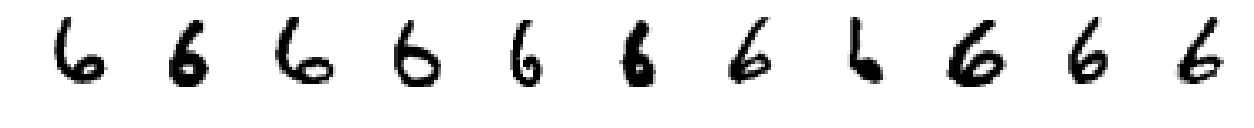

In [9]:
n_samples = 25

plt.figure(figsize=(n_samples * 2, 3))
for index in range(14,n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = X_train[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

In [10]:
Y_train[:n_samples]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

# Preparing Graph

In [11]:
X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")

caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6  # 1152 primary capsules
caps1_n_dims = 8

conv1_params = {
    "filters": 256,
    "kernel_size": 9,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu,
}

conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters
    "kernel_size": 9,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu
}

conv1 = tf.layers.conv2d(X, name="conv1", **conv1_params)
conv2 = tf.layers.conv2d(conv1, name="conv2", **conv2_params)

caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims],
                       name="caps1_raw")

def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

caps1_output = squash(caps1_raw, name="caps1_output")

caps2_n_caps = 2
caps2_n_dims = 16

init_sigma = 0.1

W_init = tf.random_normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=init_sigma, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")

batch_size = tf.shape(X)[0]
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled")

caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                       name="caps1_output_expanded")
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                   name="caps1_output_tile")
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1],
                             name="caps1_output_tiled")

caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                            name="caps2_predicted")

# Dynamic Routing algorithm
# Round 1
raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1],
                       dtype=np.float32, name="raw_weights")
routing_weights = tf.nn.softmax(raw_weights, dim=2, name="routing_weights")

weighted_predictions = tf.multiply(routing_weights, caps2_predicted,
                                   name="weighted_predictions")
weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keep_dims=True,
                             name="weighted_sum")
caps2_output_round_1 = squash(weighted_sum, axis=-2,
                              name="caps2_output_round_1")

caps2_output_round_1_tiled = tf.tile(
    caps2_output_round_1, [1, caps1_n_caps, 1, 1, 1],
    name="caps2_output_round_1_tiled")

agreement1 = tf.matmul(caps2_predicted, caps2_output_round_1_tiled,
                      transpose_a=True, name="agreement1")
# Round 2
# Routing weight update
raw_weights_round_2 = tf.add(raw_weights, agreement1,
                             name="raw_weights_round_2")
routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2,
                                        dim=2,
                                        name="routing_weights_round_2")
weighted_predictions_round_2 = tf.multiply(routing_weights_round_2,
                                           caps2_predicted,
                                           name="weighted_predictions_round_2")
weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2,
                                     axis=1, keep_dims=True,
                                     name="weighted_sum_round_2")
caps2_output_round_2 = squash(weighted_sum_round_2,
                              axis=-2,
                              name="caps2_output_round_2")
caps2_output_round_2_tiled = tf.tile(
    caps2_output_round_2, [1, caps1_n_caps, 1, 1, 1],
    name="caps2_output_round_2_tiled")

agreement2 = tf.matmul(caps2_predicted, caps2_output_round_2_tiled,
                      transpose_a=True, name="agreement2")

# Round 3
# Routing weight update
raw_weights_round_3 = tf.add(raw_weights_round_2, agreement2,
                             name="raw_weights_round_3")
routing_weights_round_3 = tf.nn.softmax(raw_weights_round_3,
                                        dim=2,
                                        name="routing_weights_round_3")
weighted_predictions_round_3 = tf.multiply(routing_weights_round_3,
                                           caps2_predicted,
                                           name="weighted_predictions_round_3")
weighted_sum_round_3 = tf.reduce_sum(weighted_predictions_round_3,
                                     axis=1, keep_dims=True,
                                     name="weighted_sum_round_3")
caps2_output_round_3 = squash(weighted_sum_round_3,
                              axis=-2,
                              name="caps2_output_round_3")
caps2_output_round_3_tiled = tf.tile(
    caps2_output_round_3, [1, caps1_n_caps, 1, 1, 1],
    name="caps2_output_round_3_tiled")

agreement3 = tf.matmul(caps2_predicted, caps2_output_round_3_tiled,
                      transpose_a=True, name="agreement3")

# Round 4
# Routing weight update
raw_weights_round_4 = tf.add(raw_weights_round_3, agreement3,
                             name="raw_weights_round_4")
routing_weights_round_4 = tf.nn.softmax(raw_weights_round_4,
                                        dim=2,
                                        name="routing_weights_round_4")
weighted_predictions_round_4 = tf.multiply(routing_weights_round_4,
                                           caps2_predicted,
                                           name="weighted_predictions_round_4")
weighted_sum_round_4 = tf.reduce_sum(weighted_predictions_round_4,
                                     axis=1, keep_dims=True,
                                     name="weighted_sum_round_4")
caps2_output_round_4 = squash(weighted_sum_round_4,
                              axis=-2,
                              name="caps2_output_round_4")
"""caps2_output_round_4_tiled = tf.tile(
    caps2_output_round_4, [1, caps1_n_caps, 1, 1, 1],
    name="caps2_output_round_4_tiled")

agreement4 = tf.matmul(caps2_predicted, caps2_output_round_4_tiled,
                      transpose_a=True, name="agreement3")
"""


caps2_output = caps2_output_round_4

def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

y_proba = safe_norm(caps2_output, axis=-2, name="y_proba")


y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_proba")

y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")

y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

T = tf.one_hot(y, depth=caps2_n_caps, name="T")

caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True,
                              name="caps2_output_norm")

present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                              name="present_error_raw")
present_error = tf.reshape(present_error_raw, shape=(-1, 2),
                           name="present_error")
present_error

absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                             name="absent_error_raw")
absent_error = tf.reshape(absent_error_raw, shape=(-1, 2),
                          name="absent_error")

L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
           name="L")

margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="margin_loss")

mask_with_labels = tf.placeholder_with_default(False, shape=(),
                                               name="mask_with_labels")

reconstruction_targets = tf.cond(mask_with_labels, # condition
                                 lambda: y,        # if True
                                 lambda: y_pred,   # if False
                                 name="reconstruction_targets")

reconstruction_mask = tf.one_hot(reconstruction_targets,
                                 depth=caps2_n_caps,
                                 name="reconstruction_mask")

reconstruction_mask_reshaped = tf.reshape(
    reconstruction_mask, [-1, 1, caps2_n_caps, 1, 1],
    name="reconstruction_mask_reshaped")

caps2_output_masked = tf.multiply(
    caps2_output, reconstruction_mask_reshaped,
    name="caps2_output_masked")

decoder_input = tf.reshape(caps2_output_masked,
                           [-1, caps2_n_caps * caps2_n_dims],
                           name="decoder_input")

n_hidden1 = 512
n_hidden2 = 1024
n_output = 28 * 28

with tf.name_scope("decoder"):
    hidden1 = tf.layers.dense(decoder_input, n_hidden1,
                              activation=tf.nn.relu,
                              name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2,
                              activation=tf.nn.relu,
                              name="hidden2")
    decoder_output = tf.layers.dense(hidden2, n_output,
                                     activation=tf.nn.sigmoid,
                                     name="decoder_output")

X_flat = tf.reshape(X, [-1, n_output], name="X_flat")
squared_difference = tf.square(X_flat - decoder_output,
                               name="squared_difference")
reconstruction_loss = tf.reduce_mean(squared_difference,
                                    name="reconstruction_loss")

alpha = 0.0005

loss = tf.add(margin_loss, alpha * reconstruction_loss, name="loss")


correct = tf.equal(y, y_pred, name="correct")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name="training_op")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
dim is deprecated, use axis instead


# Training

In [12]:
n_epochs = 10
batch_size = 50
restore_checkpoint = False
n_iterations_per_epoch = len(X_train) // batch_size
n_iterations_validation = len(valX) // batch_size
best_loss_val = np.infty
checkpoint_path = "./my_capsule_network6"

with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()

    for epoch in range(n_epochs):
        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch = X_train[(iteration-1)*batch_size:(iteration*batch_size),:]
            y_batch = Y_train[(iteration-1)*batch_size:(iteration*batch_size)]
            # Run the training operation and measure the loss:
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch,
                           mask_with_labels: True})
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")

        # At the end of each epoch,  
        # measure the validation loss and accuracy:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch = valX[(iteration-1)*batch_size:(iteration*batch_size),:]
            y_batch = valY[(iteration-1)*batch_size:(iteration*batch_size)]
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (improved)" if loss_val < best_loss_val else ""))

        # And save the model if it improved: 
        
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

Epoch: 1  Val accuracy: 97.1667%  Loss: 0.023404 (improved)
Epoch: 2  Val accuracy: 97.3333%  Loss: 0.019625 (improved)
Epoch: 3  Val accuracy: 99.3333%  Loss: 0.007622 (improved)
Epoch: 4  Val accuracy: 99.1667%  Loss: 0.007698
Epoch: 5  Val accuracy: 99.1667%  Loss: 0.006874 (improved)
Epoch: 6  Val accuracy: 99.5000%  Loss: 0.004637 (improved)
Epoch: 7  Val accuracy: 99.3333%  Loss: 0.004713
Epoch: 8  Val accuracy: 99.5000%  Loss: 0.004191 (improved)
Epoch: 9  Val accuracy: 99.5000%  Loss: 0.004698
Epoch: 10  Val accuracy: 99.6667%  Loss: 0.003761 (improved)


# Testing

In [13]:
n_iterations_test = len(testX) // batch_size
checkpoint_path = "./my_capsule_network6"
with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    pred = []
    loss_tests = []
    acc_tests = []
    for iteration in range(1, n_iterations_test + 1):
        X_batch = testX[(iteration-1)*batch_size:(iteration*batch_size),:]
        y_batch = testY[(iteration-1)*batch_size:(iteration*batch_size)]
        loss_test, acc_test = sess.run(
                [loss, accuracy],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch})
        loss_tests.append(loss_test)
        pred.append(y_pred)
        acc_tests.append(acc_test)
        print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                  iteration, n_iterations_test,
                  iteration * 100 / n_iterations_test),
              end=" " * 10)
    loss_test = np.mean(loss_tests)
    #print(tf.confusion_matrix())
    acc_test = np.mean(acc_tests)
    print("\rFinal test accuracy: {:.4f}%  Loss: {:.6f}".format(
        acc_test * 100, loss_test))


INFO:tensorflow:Restoring parameters from ./my_capsule_network6
Final test accuracy: 99.1429%  Loss: 0.005112 


# Predictions for training set

In [14]:
with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    y_pred_value = sess.run(
            [y_pred],
            feed_dict={X: X_train.reshape([-1, 28, 28, 1]),
                       y: np.array([], dtype=np.int64)})
pred = np.array(y_pred_value).T
pred = pred.flatten()
Y_train = Y_train.flatten()

from sklearn.metrics import classification_report,confusion_matrix
print("")
print("Confusion Matrix is :")
print(confusion_matrix(Y_train, pred, labels=None, sample_weight=None))
print("")
print("Classification report is : ")
print("")
print(classification_report(Y_train, pred, labels=None, sample_weight=None))

INFO:tensorflow:Restoring parameters from ./my_capsule_network6

Confusion Matrix is :
[[5417    0]
 [   0  321]]

Classification report is : 

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      5417
        1.0       1.00      1.00      1.00       321

avg / total       1.00      1.00      1.00      5738



# Predictions for validation set

In [15]:
with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    y_pred_value = sess.run(
            [y_pred],
            feed_dict={X: valX.reshape([-1, 28, 28, 1]),
                       y: np.array([], dtype=np.int64)})
pred = np.array(y_pred_value).T
pred = pred.flatten()
valY = valY.flatten()

from sklearn.metrics import classification_report,confusion_matrix
print("")
print("Confusion Matrix is :")
print(confusion_matrix(valY, pred, labels=None, sample_weight=None))
print("")
print("Classification report is : ")
print("")
print(classification_report(valY, pred, labels=None, sample_weight=None))

INFO:tensorflow:Restoring parameters from ./my_capsule_network6

Confusion Matrix is :
[[501   0]
 [  3 134]]

Classification report is : 

             precision    recall  f1-score   support

        0.0       0.99      1.00      1.00       501
        1.0       1.00      0.98      0.99       137

avg / total       1.00      1.00      1.00       638



# Test set prediction

In [16]:
with tf.Session(config=tf.ConfigProto(
      allow_soft_placement=True, log_device_placement=True)) as sess:
    saver.restore(sess, checkpoint_path)
    y_pred_value = sess.run(
            [y_pred],
            feed_dict={X: testX.reshape([-1, 28, 28, 1]),
                       y: np.array([], dtype=np.int64)})
pred = np.array(y_pred_value).T
pred = pred.flatten()
testY = testY.flatten()

from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,accuracy_score
print("")
print("Accuracy is : ", accuracy_score(testY,pred))
print("")
print("AUROC is : ", roc_auc_score(testY,pred))
print("")
print("Confusion Matrix is :")
print(confusion_matrix(testY, pred, labels=None, sample_weight=None))
print("")
print("Classification report is : ")
print("")
print(classification_report(testY, pred, labels=None, sample_weight=None))

INFO:tensorflow:Restoring parameters from ./my_capsule_network6

Accuracy is :  0.9917808219178083

AUROC is :  0.9765364277768466

Confusion Matrix is :
[[955   3]
 [  6 131]]

Classification report is : 

             precision    recall  f1-score   support

        0.0       0.99      1.00      1.00       958
        1.0       0.98      0.96      0.97       137

avg / total       0.99      0.99      0.99      1095



# AUROC

In [12]:
checkpoint_path = "./my_capsule_network6"
with tf.Session(config=tf.ConfigProto(
      allow_soft_placement=True, log_device_placement=True)) as sess:
    saver.restore(sess, checkpoint_path)
    prob = sess.run(
            [y_proba],
            feed_dict={X: testX.reshape([-1, 28, 28, 1]),
                       y: np.array([], dtype=np.int64)})
prob = np.array(prob)
probs = np.array(prob[0,:,0,1,0])
probs = probs.flatten()
testY = testY.flatten()

from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,accuracy_score
print("AUROC is : ", roc_auc_score(testY,probs))
print("")

INFO:tensorflow:Restoring parameters from ./my_capsule_network6
AUROC is :  0.9997333252061015

